# Machine Learning Prediction - Data Challenge

## by SNCF-Transilien

Introduction au problème

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [2]:
file_path = 'data/'

X_train = pd.read_csv(file_path + 'train_f_x.csv') #  entre le 1er janvier 2015 et le 31 décembre 2022 (soit 2922 jours)
y_train = pd.read_csv(file_path + 'y_train_sncf.csv', index_col=0)
X_test = pd.read_csv(file_path + 'test_f_x_THurtzP.csv', index_col=0) # entre le 1er janvier 2023 et le 30 juin 2023 (soit 181 jours) 

In [3]:
X_train['index'] = X_train['date'].astype(str) + '_' + X_train['station'].astype(str)
X_train = X_train.set_index('index')

X_train['date'] = pd.to_datetime(X_train['date'])
X_test['date'] = pd.to_datetime(X_test['date'])

In [4]:
X_train

,date,station,job,ferie,vacances
index,,,,,
2015-01-01_1J7,2015-01-01,1J7,1,1,1
2015-01-01_O2O,2015-01-01,O2O,1,1,1
2015-01-01_8QR,2015-01-01,8QR,1,1,1
2015-01-01_UMC,2015-01-01,UMC,1,1,1
2015-01-01_FK3,2015-01-01,FK3,1,1,1
...,...,...,...,...,...
2022-12-31_V2P,2022-12-31,V2P,0,0,1
2022-12-31_N9K,2022-12-31,N9K,0,0,1
2022-12-31_P6E,2022-12-31,P6E,0,0,1


Text(0.5, 1.0, 'Evolution du nombre de validations par jour')

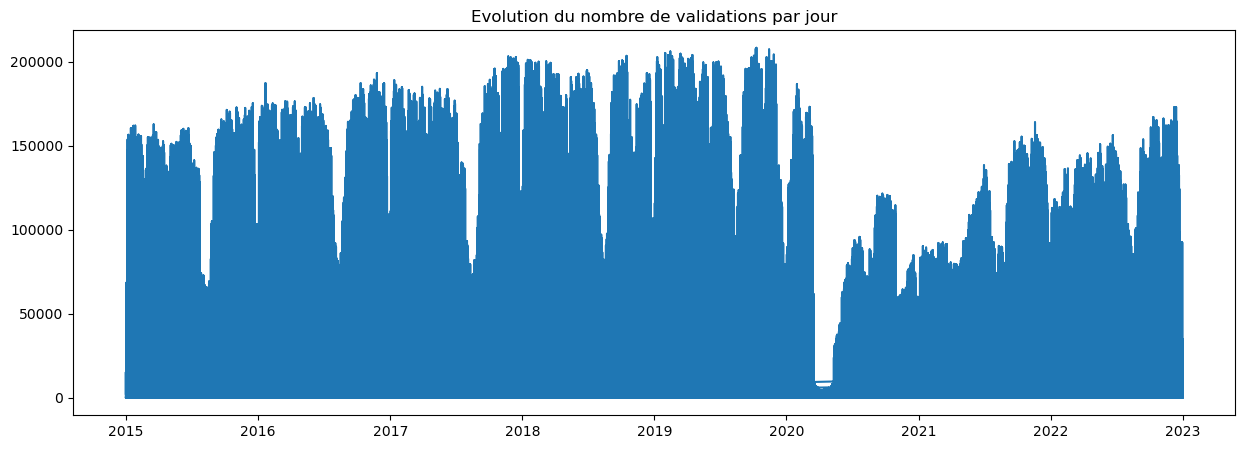

In [5]:
plt.figure(figsize=(15, 5))
plt.plot(X_train['date'], y_train['y'])
plt.title('Evolution du nombre de validations par jour')


Text(0.5, 1.0, 'Station 1J7')

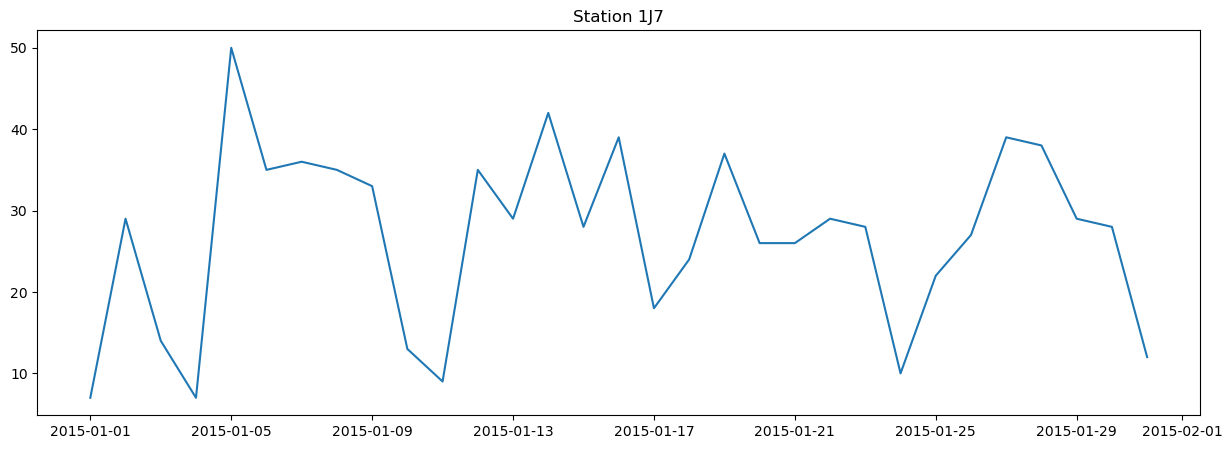

In [6]:
X_plot = X_train.loc[(X_train.date < '2015-02-01') & (X_train.station == '1J7')] #FIXME
plt.figure(figsize=(15, 5))
plt.plot(X_plot['date'], y_train.loc[X_plot.index, 'y'])
plt.title('Station 1J7')


In [7]:
def create_features(df):
    ''' Create features from date '''
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofweek'] = df['date'].dt.dayofweek
    return df

In [8]:
def add_lags(df_x, df_y):
    ''' Add lags '''
    target_map = df_y['y'].to_dict()
    
    df_x['lag7d'] = (df_x['date'] - pd.Timedelta('7 days')).dt.strftime('%Y-%m-%d') + '_' + df_x['station']
    df_x['lag7d'] = df_x['lag7d'].map(target_map)

    df_x['lag14d'] = (df_x['date'] - pd.Timedelta('14 days')).dt.strftime('%Y-%m-%d') + '_' + df_x['station']
    df_x['lag14d'] = df_x['lag14d'].map(target_map)

    df_x['lag28d'] = (df_x['date'] - pd.Timedelta('28 days')).dt.strftime('%Y-%m-%d') + '_' + df_x['station']
    df_x['lag28d'] = df_x['lag28d'].map(target_map)

    df_x['lag365d'] = (df_x['date'] - pd.Timedelta('365 days')).dt.strftime('%Y-%m-%d') + '_' + df_x['station']
    df_x['lag365d'] = df_x['lag365d'].map(target_map)

    return df_x


In [9]:
X_train = create_features(X_train)
X_train = add_lags(X_train, y_train)
X_test = create_features(X_test)
X_test = add_lags(X_test, y_train)

In [10]:
#Teste, alguns valores do final realmente nao estao no csv
#a = (X_train['date'] - pd.Timedelta('365 days')).dt.strftime('%Y-%m-%d') + '_' + X_train['station']
#a.tail()

In [11]:
X_train.tail()

,date,station,job,ferie,vacances,day,month,year,dayofweek,lag7d,lag14d,lag28d,lag365d
index,,,,,,,,,,,,,
2022-12-31_V2P,2022-12-31,V2P,0,0,1,31,12,2022,5,1063.0,889.0,1294.0,952.0
2022-12-31_N9K,2022-12-31,N9K,0,0,1,31,12,2022,5,417.0,395.0,695.0,376.0
2022-12-31_P6E,2022-12-31,P6E,0,0,1,31,12,2022,5,74.0,115.0,121.0,NaN
2022-12-31_BDC,2022-12-31,BDC,0,0,1,31,12,2022,5,53.0,90.0,95.0,NaN
2022-12-31_W14,2022-12-31,W14,0,0,1,31,12,2022,5,10.0,24.0,20.0,NaN


<Axes: xlabel='year', ylabel='y'>

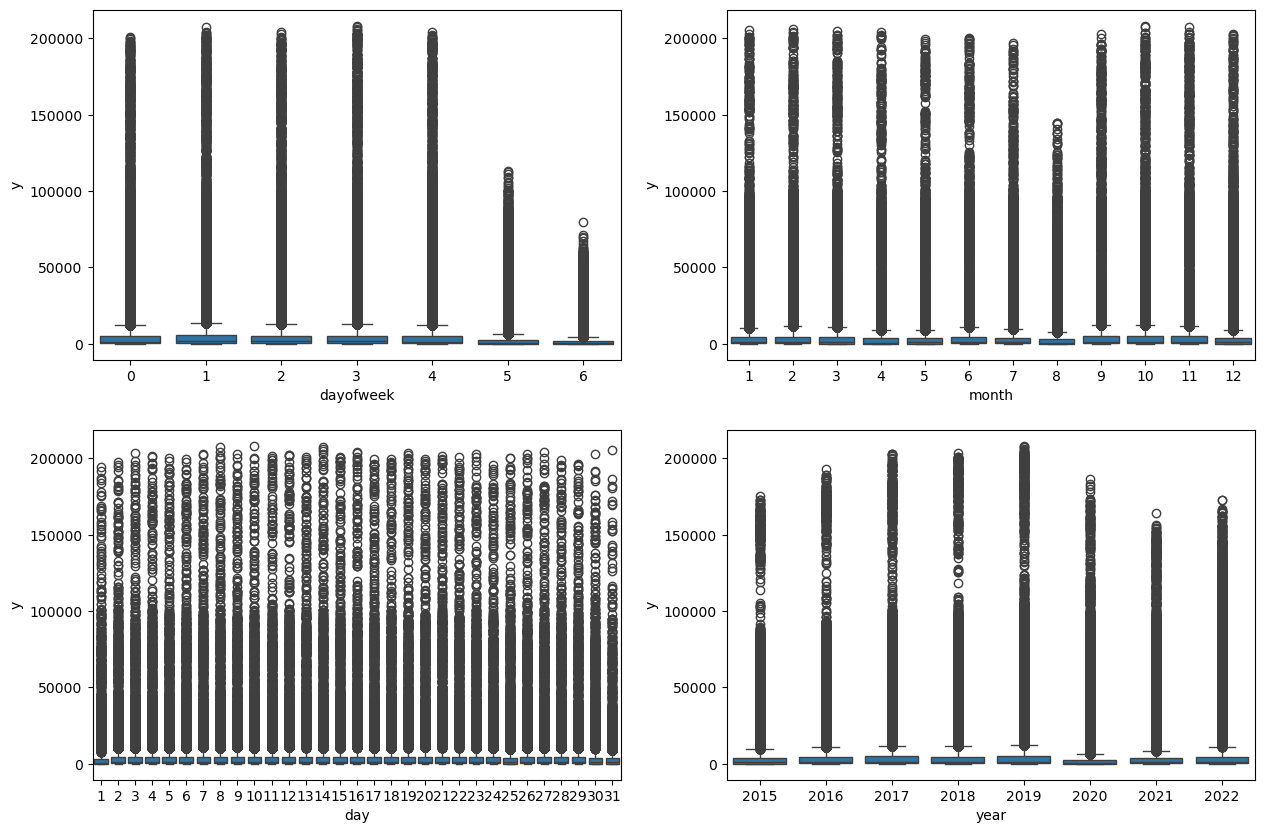

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.boxplot(x=X_train.dayofweek, y=y_train.y, ax=ax[0, 0])
sns.boxplot(x=X_train.month, y=y_train.y, ax=ax[0, 1])
sns.boxplot(x=X_train.day, y=y_train.y, ax=ax[1, 0])
sns.boxplot(x=X_train.year, y=y_train.y, ax=ax[1, 1])

In [12]:
# Drop the 'date' column and convert 'station' to categorical
X_train = X_train.drop(columns=['date'])
X_train['station'] = X_train['station'].astype('category')

# Apply the same preprocessing steps to X_test
X_test = X_test.drop(columns=['date'])
X_test['station'] = X_test['station'].astype('category')

In [13]:
reg = xgb.XGBRegressor(enable_categorical=True, early_stopping_rounds=50)

param_grid = {
    'learning_rate': [0.01, 0.1, 0.05],
    'n_estimators': [500, 700],
}

grid_search = GridSearchCV(estimator=reg,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',  
                           cv=3,  
                           verbose=10,  
                           n_jobs=-1, 
                           refit=True)

grid_search.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=True)
print("Best params:", grid_search.best_params_)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3; 1/6] START learning_rate=0.01, n_estimators=500........................
[CV 2/3; 1/6] START learning_rate=0.01, n_estimators=500........................
[CV 3/3; 1/6] START learning_rate=0.01, n_estimators=500........................
[CV 1/3; 2/6] START learning_rate=0.01, n_estimators=700........................
[CV 2/3; 2/6] START learning_rate=0.01, n_estimators=700........................
[0]	validation_0-rmse:9592.69095
[1]	validation_0-rmse:9502.94701
[CV 3/3; 2/6] START learning_rate=0.01, n_estimators=700........................
[2]	validation_0-rmse:9414.14715
[0]	validation_0-rmse:9593.36485
[3]	validation_0-rmse:9326.29135
[1]	validation_0-rmse:9504.16562
[0]	validation_0-rmse:9592.36492
[4]	validation_0-rmse:9239.36495
[2]	validation_0-rmse:9415.87865
[1]	validation_0-rmse:9502.26981
[CV 1/3; 3/6] START learning_rate=0.1, n_estimators=500.........................
[5]	validation_0-rmse:9153.33998
[3]	valida

In [ ]:
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=True)

[0]	validation_0-rmse:9230.45841
[1]	validation_0-rmse:8801.54870
[2]	validation_0-rmse:8395.09947
[3]	validation_0-rmse:8010.37188
[4]	validation_0-rmse:7646.13363
[5]	validation_0-rmse:7301.47867
[6]	validation_0-rmse:6975.15272
[7]	validation_0-rmse:6666.73579
[8]	validation_0-rmse:6374.80845
[9]	validation_0-rmse:6098.21049
[10]	validation_0-rmse:5836.86132
[11]	validation_0-rmse:5589.86412
[12]	validation_0-rmse:5357.14916
[13]	validation_0-rmse:5137.18202
[14]	validation_0-rmse:4929.72422
[15]	validation_0-rmse:4734.68804
[16]	validation_0-rmse:4550.68468
[17]	validation_0-rmse:4377.11193
[18]	validation_0-rmse:4213.32019
[19]	validation_0-rmse:4060.18465
[20]	validation_0-rmse:3915.09357
[21]	validation_0-rmse:3778.17993
[22]	validation_0-rmse:3648.77713
[23]	validation_0-rmse:3528.79954
[24]	validation_0-rmse:3415.18061
[25]	validation_0-rmse:3310.45206
[26]	validation_0-rmse:3210.95615
[27]	validation_0-rmse:3118.34987
[28]	validation_0-rmse:3031.35009
[29]	validation_0-rmse:2

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=700, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
#Primeira versao, usando parametros default
#reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, enable_categorical=True, learning_rate = 0.01) #colocar GridSearchCV dps #TODO
#reg.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=True)

<Axes: title={'center': 'Feature importance'}, ylabel='feature'>

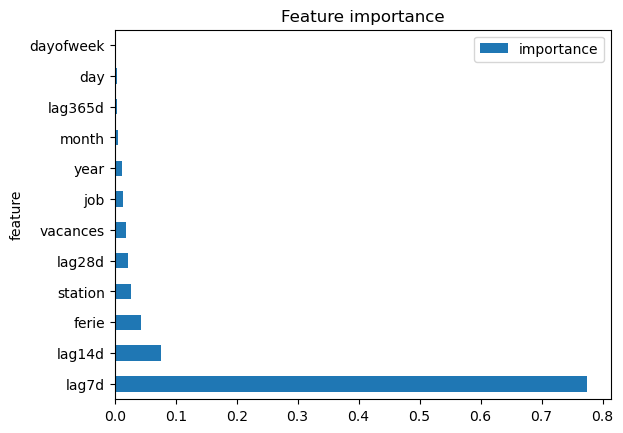

In [15]:
#feature importances
fi = pd.DataFrame({'feature': X_train.columns, 'importance': best_model.feature_importances_}).sort_values('importance', ascending=False)
fi.plot(kind='barh', x='feature', y='importance', title='Feature importance')

In [16]:
# Predict using the trained model
y_pred = pd.DataFrame(index=X_test.index)
y_pred['y'] = best_model.predict(X_test).astype(int)
y_pred.to_csv(file_path + 'y_pred.csv')

Text(0.5, 1.0, 'Station 1J7')

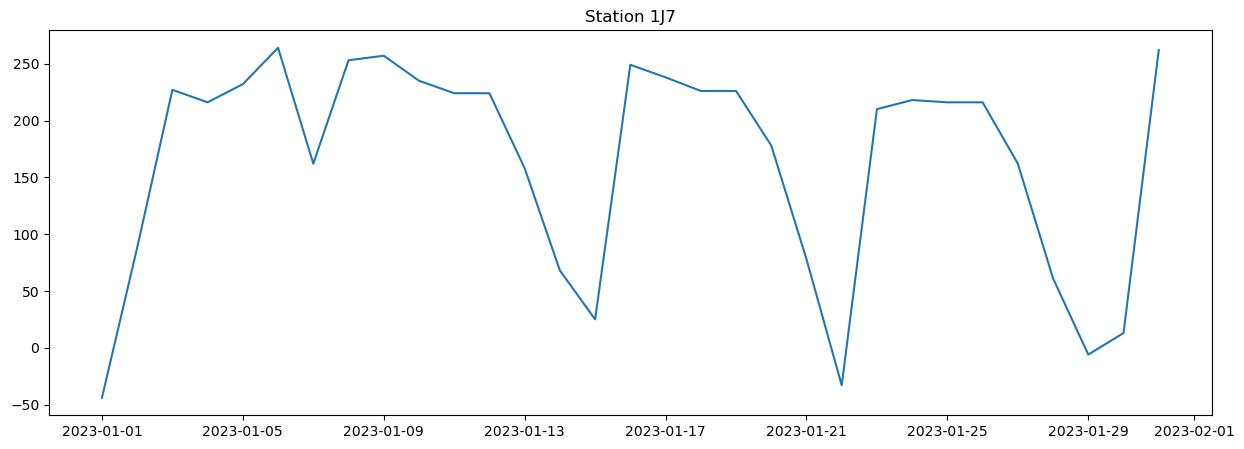

In [17]:
X_test2 = pd.read_csv(file_path + 'test_f_x_THurtzP.csv', index_col=0)
X_test2['date'] = pd.to_datetime(X_test2['date'])
X_plot = X_test2.loc[(X_test2.date < '2023-02-01') & (X_test2.station == '1J7')] #FIXME
plt.figure(figsize=(15, 5))
plt.plot(X_plot['date'], y_pred.loc[X_plot.index, 'y'])
plt.title('Station 1J7')

Best params: {'learning_rate': 0.05, 'n_estimators': 700} -> Score = 166.93